In [1]:
%load_ext autoreload

%autoreload 2
from astropy.io import fits as fits
import matplotlib.pyplot as plt
import pickle
import sys
import emcee
import numpy as np
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
from astropy.table import Table, QTable, hstack, vstack
from astropy import units as u
import corner
cosmo_astropy = FlatLambdaCDM(H0=71.0, Om0=0.265, Ob0 = 0.0448)
import iminuit
from iminuit import Minuit
cosmo_astropy.critical_density(0.4).to(u.Msun / u.Mpc**3).value


sys.path.append('/pbs/throng/lsst/users/cpayerne/CLCosmo_Sim/cluster_abundance')
import CL_COUNT_modeling_completeness as comp
import CL_COUNT_modeling_purity as pur
import CL_COUNT_modeling_halo_mass_function as hmf
import CL_COUNT_modeling_richness_mass_relation as rm_relation
import CL_MASS_cluster_mass as cl_mass
import CL_COUNT_cluster_abundance as cl_count
import CL_COUNT_class_likelihood as likelihood
import CL_LENSING_cluster_lensing as cl_lensing

In [2]:
name = '/pbs/throng/lsst/users/cpayerne/CLMassDC2/data/matched_pairs_Mfofcut.fits'
dat = fits.open(name)
#mask = (match['redshift_1'] > .2)*(match['redshift_1'] < 1)
#mask = mask*(match['obs_2'] > 20)*(match['obs_1'] > 3e13)*(match['obs_2'] < 120)
#match = match[mask]

In [3]:
dat_open= dat[1].data

In [4]:
#dat_open

In [5]:
richness = dat_open['cat1_richness']
redshift = dat_open['cat2_z']
M200c = dat_open['cat2_M200c']

In [6]:
table = Table()

In [7]:
table['richness'] = dat_open['cat1_richness']
table['M200c'] = dat_open['cat2_M200c']
table['redshift'] = dat_open['cat1_ztrue_cg']

In [8]:
table_cut = table[(table['M200c'] > 1e13)*(table['richness'] < 500)*(table['richness'] > 0)*(table['redshift'] < 1)*(table['redshift'] > .2)]

In [10]:
import scipy
u = np.linspace(-50, 50, 600)
pu = 0.5*(1 + scipy.special.erf(u))
def p_f(x):
    return np.interp(x, u, pu, left=None, right=None)

In [11]:
def lnLikelihood(p):
    proxy_mu0, proxy_muz, proxy_mulog10m, proxy_sigma0, proxy_sigmaz, proxy_sigmalog10m = p
    params = np.log10(10**14.2), .4, proxy_mu0, proxy_muz, proxy_mulog10m, proxy_sigma0, proxy_sigmaz, proxy_sigmalog10m 
    mu = rm_relation.proxy_mu_f(np.log10(table_cut['M200c']), table_cut['redshift'],  params)
    sigma= rm_relation.proxy_sigma_f(np.log10(table_cut['M200c']), table_cut['redshift'],  params)
    #pM = np.exp(-.5*(np.log(table['M200c'])-mu_lnm)**2/(sigma_int_correct**2))/(sigma_int_correct*table['M200c'])
    pdf = table_cut['richness']*rm_relation.pdf_richness_mass_relation(table_cut['richness'], np.log10(table_cut['M200c']), table_cut['redshift'], params)
    normalx = np.array((np.log(5) - mu)/(np.sqrt(2)*sigma))
    normalp =  p_f(normalx)
    
    pdf = pdf/(1-normalp)
    
    if np.isnan(np.sum(np.log(pdf))): return -np.inf

    return np.sum(np.log(pdf))

In [12]:
initial = [3.15554779, -0.01047953,  2.1415984 ,  0.53798303, -0.1853501 ,
       -0.12253216]
lnLikelihood(initial)

-7895.084109931767

In [19]:
from multiprocessing import Pool
nwalker=20
pos=.001*np.random.randn(nwalker,6) + initial
#with Pool() as pool:
sampler = emcee.EnsembleSampler(nwalker, 6, lnLikelihood, )#pool=pool)
sampler.run_mcmc(pos, 600, progress=True);
flat_samples1 = sampler.get_chain(discard=10, thin=3, flat=True)

100%|██████████| 600/600 [02:43<00:00,  3.68it/s]


[ 3.08802392 -0.01307768  2.29139231  0.55595341 -0.12814781 -0.03971411]


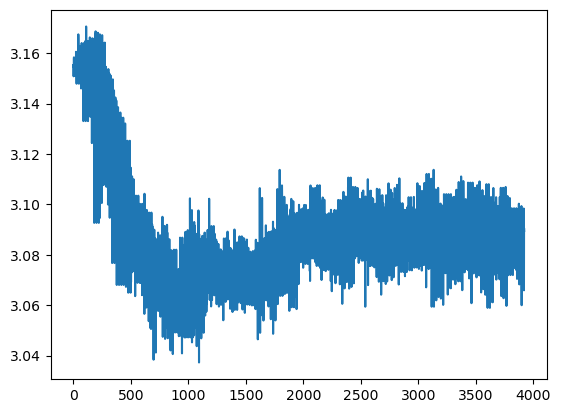

In [21]:
plt.plot(flat_samples1[:,0])
np.mean(flat_samples1[9000:], axis=0)
print(np.mean(flat_samples1[3000:], axis=0))
np.save('fiducial.pkl',flat_samples1[3000:],)

In [22]:
p = np.mean(flat_samples1[3000:], axis=0)
params = [np.log10(10**14.2), .4]
params = params + list(p)

In [23]:
p

array([ 3.08802392, -0.01307768,  2.29139231,  0.55595341, -0.12814781,
       -0.03971411])

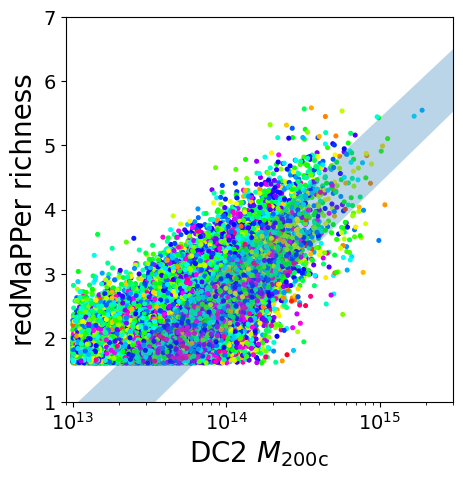

In [24]:
plt.figure(figsize=(5,5))
plt.tick_params(axis='both', which = 'major', labelsize= 14)
#plt.grid(True, which="both")
plt.scatter( table['M200c'], np.log(table['richness']),c=table['redshift'], s=7, cmap='hsv')
m = np.linspace(1e13, 3e15, 10)
mu = rm_relation.proxy_mu_f(np.log10(m) , .6,  params,)
sigma = rm_relation.proxy_sigma_f(np.log10(m) , .6,  params,)
plt.fill_between(m, mu+ sigma, mu- sigma ,alpha=.3)
#plt.colorbar().set_label(label=r'redshift',size=20,)
plt.ylim(1, 7)
plt.xlim(9e12, 3e15)
#plt.yscale('log')
plt.xscale('log')
plt.ylabel(r'redMaPPer richness', fontsize=20)
plt.xlabel(r'DC2 $M_{\rm 200c}$', fontsize=20)
radius = np.linspace(4, 20, 100)

In [ ]:
np.mean(flat_samples1[9000:], axis=0)
np.save('fiducial.pkl',flat_samples1[9000:],)